In [40]:
import numpy as np
import glob
import emcee as mc
import h5py
import sys
import matplotlib.pyplot as plt
from matplotlib import rc

sys.path.append("./../")
from support import *

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [61]:
# Prior boundaries
priorDict = {
    'lmbda':(-5,4),
    'mMax':(60,100),
    'm0':(20,100),
    'sigM':(1,10),
    'fPeak':(0,1),
    'bq':(-2,10),
    'sig_kappa':6.,
    'mu0':(-1,1),
    'log_sigma0':(-1.5,0.5),
    'alpha':(-2.,1),
    'beta':(-2,1.5),
    'mMin':5.
    }

# Load mock detections
mockDetections = h5py.File('/home/thomas.callister/RedshiftDistributions/BBH-spin-q-correlations/input/o3a_bbhpop_inj_info.hdf','r')
ifar_1 = mockDetections['injections']['ifar_gstlal'].value
ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
detected = (ifar_1>1) + (ifar_2>1) + (ifar_3>1)
m1_det = mockDetections['injections']['mass1_source'].value[detected]
m2_det = mockDetections['injections']['mass2_source'].value[detected]
s1z_det = mockDetections['injections']['spin1z'].value[detected]
s2z_det = mockDetections['injections']['spin2z'].value[detected]
z_det = mockDetections['injections']['redshift'].value[detected]

mockDetectionsO1O2 = h5py.File('/home/thomas.callister/RedshiftDistributions/BBH-spin-q-correlations/input/injections_O1O2an_spin.h5','r')
m1_det = np.append(m1_det,mockDetectionsO1O2['mass1_source'])
m2_det = np.append(m2_det,mockDetectionsO1O2['mass2_source'])
s1z_det = np.append(s1z_det,mockDetectionsO1O2['spin1z'])
s2z_det = np.append(s2z_det,mockDetectionsO1O2['spin2z'])
z_det = np.append(z_det,mockDetectionsO1O2['redshift'])

pop_reweight = injection_weights(m1_det,m2_det,s1z_det,s2z_det,z_det,mMin=priorDict['mMin'])

injectionDict = {
        'm1':m1_det,
        'm2':m2_det,
        's1z':s1z_det,
        's2z':s2z_det,
        'z':z_det,
        'weights':pop_reweight
        }

<ipython-input-61-8b9c17500f77>:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_1 = mockDetections['injections']['ifar_gstlal'].value
<ipython-input-61-8b9c17500f77>:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
<ipython-input-61-8b9c17500f77>:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
<ipython-input-61-8b9c17500f77>:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m1_det = mockDetections['injections']['mass1_source'].value[detected]
<ipython-input-61-8b9c17500f77>:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m2_det = mockDetections['injections']['mass2_source'].value[detected]
<ipython-input-61-8b9c17500f77>:25: H5pyDeprecationWarning: datase

In [62]:
# Define parameters
lmbda = -2.5
mMax = 85.
m0 = 33.
sigM = 5.
fPeak = 0.1
bq = 1.1
kappa = 1.5
mu0 = 0.1
log_sigma0 = -1.

# Unpack injections
m1_det = injectionDict['m1']
m2_det = injectionDict['m2']
s1z_det = injectionDict['s1z']
s2z_det = injectionDict['s2z']
z_det = injectionDict['z']
pop_reweight = injectionDict['weights']
q_det = m2_det/m1_det
mtot_det = m1_det+m2_det
X_det = (m1_det*s1z_det + m2_det*s2z_det)/(m1_det+m2_det)

p_det_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
p_det_z = np.power(1.+z_det,kappa-1.)

# PLPeak distribution on p(m1)
p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
p_det_m1_pl[m1_det>mMax] = 0
p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
p_det_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl

mMin = priorDict['mMin']

alphas = np.linspace(priorDict['alpha'][0],priorDict['alpha'][1],15)
betas = np.linspace(priorDict['beta'][0],priorDict['beta'][1],16)
log_Xi =  np.zeros((alphas.size,betas.size))
log_Neff =  np.zeros((alphas.size,betas.size))

for i,alpha in enumerate(alphas):
    for ii,beta in enumerate(betas):

        # Reweight injection probabilities
        mu_q = mu0 + alpha*(q_det-0.5)
        log_sigma_q = log_sigma0 + beta*(q_det-0.5)
        p_det_Xeff = calculate_Gaussian(X_det, mu_q, 10.**(2.*log_sigma_q),-1.,1.)

        # Construct full weighting factors
        det_weights = p_det_Xeff*p_det_m1*p_det_m2*p_det_z*pop_reweight
        det_weights[np.where(det_weights!=det_weights)] = 0.

        nEvents = 44
        log_Xi[i,ii] = np.log10(np.sum(det_weights))
        log_Neff[i,ii] = np.log10(np.sum(det_weights)/np.max(det_weights))

<ipython-input-63-7e839f368370>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(alphas,betas,10.**(log_Xi.T-np.min(log_Xi)),cmap='Blues')


Text(0, 0.5, '$\\beta$')

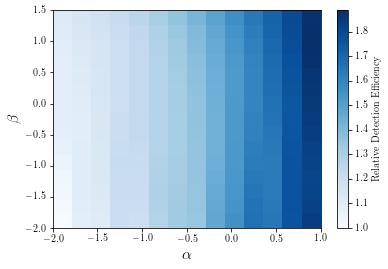

In [63]:
fig,ax = plt.subplots()
im = ax.pcolormesh(alphas,betas,10.**(log_Xi.T-np.min(log_Xi)),cmap='Blues')
plt.colorbar(im,ax=ax,label="Relative Detection Efficiency")
ax.set_xlabel(r'$\alpha$',fontsize=16)
ax.set_ylabel(r'$\beta$',fontsize=16)